In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import math
from scipy.optimize import fsolve
from tqdm.notebook import tqdm
np.set_printoptions(threshold=np.inf)

In [2]:
# Parameters
nx, ny = 100, 50 # Mise à jour des valeurs de nx et ny
Lx, Ly = 10, 5   # Mise à jour des valeurs de Lx et Ly
nt = 1000
dt = 1
dx = Lx/(nx-1)
dy = Ly/(ny-1)
h = 10
T0, T1, Ta = 283.15, 303.15, 293.15  # temperatures in Kelvin (initial, boundary, and ambient)
k = 380.0  # thermal conductivity of copper in W/(m·K)
rho = 8960.0  # density of copper in kg/m³
cp = 385.0  # thermal capacity of copper in J/(kg·K)
alpha = k / (rho * cp)  # thermal diffusivity of copper in m²/s

In [3]:
# Definition of functions
def equation(x, L, h, l):
    return x * np.tan(L * x) - h / l

def find_first_n_solutions(L, h, l, n):
    solutions = []
    guess = 0.1
    while len(solutions) < n:
        solution = fsolve(equation, guess, args=(L, h, l))
        solution = solution[0]  # Convertir la solution en un nombre réel
        if not any(abs(sol - solution) < 1e-7 for sol in solutions):  # Vérifier si la solution est déjà dans la liste
            solutions.append(solution)
        guess += 0.1  # Augmenter la supposition initiale pour la prochaine solution
        # print(solutions)
    return solutions

def serie(Lx, Ly, h, l, x, y, n, liste_solutions):
    sum = 0
    for k in range(0, n+1):
        a = liste_solutions[k]
        x_k = (np.cos(a*y)*np.cosh(a*(Ly-x)))/(((a**2+(h/l)**2)*Lx+h/l)*np.cos(a*Lx)*np.cosh(a*Ly))
        sum += x_k
    # print("sum =", sum)
    return sum

def generate_analytical_profile(nx, ny, Lx, Ly, T1, Ta, h, k, n, liste_solutions):

    # Créer des grilles de points x et y
    x = np.linspace(0, Lx, nx)
    y = np.linspace(0, Ly, ny)

    # Initialiser le profil analytique
    T_analytical = np.zeros((nx, ny))

    # Calculer le profil analytique en utilisant une formule spécifique
    for i in range(ny):
        for j in range(nx):
            x = 1 - i/nx
            y = 1 - j/ny
            # Mettre en œuvre la formule analytique en fonction de x, y et d'autres paramètres
            sum = serie(Lx, Ly, h, k, x, y, n, liste_solutions)
            T_analytical[i, j] = (Ta + 2*(T1-Ta)*sum*h/k)

    # Tracer le profil analytique
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(T_analytical, cmap='hot', interpolation='nearest')
    colorbar = fig.colorbar(im, ax=ax)
    colorbar.set_label('Température')
    # plt.imshow(T_analytical, cmap='hot', origin='lower', extent=[0, Lx, 0, Ly])
    # plt.colorbar(label='Température')
    # plt.xlabel('x')
    # plt.ylabel('y')
    plt.title('Profil de température analytique')
    # plt.gca().set_ylim(50, 0)
    plt.show()
    return T_analytical


def TDMA(a, b, c, d):
    n = len(d)
    w = np.zeros(n-1,float)
    g = np.zeros(n, float)
    p = np.zeros(n,float)

    w[0] = c[0]/b[0]
    g[0] = d[0]/b[0]

    for i in range(1,n-1):
        w[i] = c[i]/(b[i] - a[i-1]*w[i-1])
    for i in range(1,n):
        g[i] = (d[i] - a[i-1]*g[i-1])/(b[i] - a[i-1]*w[i-1])
    p[n-1] = g[n-1]
    for i in range(n-1,0,-1):
        p[i-1] = g[i-1] - w[i-1]*p[i]
    return p

# Méthode ADI
def ADI_method(T, nx, ny, nt, dt, dx, dy, alpha, T1, h, Ta, k):
    for it in tqdm(range(nt)):
        T_old = T.copy()

        # Étape 1 : résoudre dans la direction x
        for i in range(1, nx-1):
            a = np.full(nx-1, -alpha*dt/(2*dx**2))
            b = np.full(nx-1, 1 + alpha*dt/(dx**2))
            c = np.full(nx-1, -alpha*dt/(2*dx**2))
            d = T_old[i, 1:-1] + alpha*dt/(2*dx**2) * (T_old[i+1, 1:-1] - 2*T_old[i, 1:-1] + T_old[i-1, 1:-1])

            # Appliquer les conditions aux limites
            d[0] += alpha*dt/(2*dx**2) * T_old[i, 1]
            d[-1] += alpha*dt/(2*dx**2) * (2*dx*h*(Ta-T_old[-1, i])/(2*dx*h+alpha) + T_old[-2, i])
            # print(d[-1])
            # print(d[0], d[-1])
            T[i, 1:-1] = TDMA(a, b, c, d)

        T_old = T.copy()

        # Étape 2 : résoudre dans la direction y
        for j in range(1, ny-1):
            a = np.full(ny-1, -alpha*dt/(2*dy**2))
            b = np.full(ny, 1 + alpha*dt/(dy**2))
            c = np.full(ny-1, -alpha*dt/(2*dy**2))
            d = T_old[1:-1, j] + alpha*dt/(2*dy**2) * (T_old[1:-1, j+1] - 2*T_old[1:-1, j] + T_old[1:-1, j-1])
            
            # Appliquer les conditions aux limites
            d[-1] += alpha*dt/(2*dy**2) * T1
            d[0] += alpha*dt/(2*dy**2) * T_old[1, j]
            # print(d[0], d[-1])
            T[1:-1, j] = TDMA(a, b, c, d)

        
        # Appliquer la condition de conducto-convection à x = Lx
        T[:, -1] = (2*dx*h*Ta + k*T[-2, :]) / (2*dx*h + k)

    return T

In [4]:
# Solution numérique

# Initialiser le profil de température à T0
T = np.full((nx, ny), T0)

# Appliquer les conditions aux limites initiales
T[0, :] = T[1, :] # x = 0, isolation thermique
T[:, 0] = T[:, 1] # y = Ly, isolation thermique
T[-1, :] = T1  # y = 0, conduction
T[:, -1] = T[:, -2] - h * (T[:, -2] - Ta) * dx / k # x = Lx, convection

# print(T)

# Exécuter la méthode ADI
T = ADI_method(T, nx, ny, nt, dt, dx, dy, alpha, T1, h, Ta, k)
T[:, -1] = (2*dx*h*Ta + k*T[:, -2]) / (2*dx*h + k) # x = Lx, convection
# T[:, -1] = T[:, -2] - h * (T[:, -2] - Ta) * dx / k # x = Lx, convection
# print(T)
# Créer la figure en dehors de la boucle

T_numerical = T
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(T_numerical, cmap='hot', interpolation='nearest')
colorbar = fig.colorbar(im, ax=ax)
colorbar.set_label('Temperature')
ax.set_title(f"Final temperature profile")    
plt.show()  
# Display the plot

# print(T)

IndexError: index 50 is out of bounds for axis 1 with size 50

[0.1615133463256019, 3.14994681915841, 6.2873707825894245, 9.427569318778614, 12.56846440642214, 15.709638402931954, 18.850951913237072, 21.99234516315582, 25.13378825671064, 28.27526458206509, 31.41676417096236, 34.55828067946498, 37.69980987803538, 40.84134883840871, 43.98289546889898, 47.12444823557225, 50.26600598793304, 53.40756784620251, 56.54913312608356, 59.690701287339586, 62.832271897777154, 65.97384460752194, 69.1154191303116, 72.25699522966788, 75.39857270852323, 78.54015140134506, 81.6817311680507, 84.82331188933352, 87.96489346291472, 91.10647580062682, 94.24805882605772, 97.38964247266017, 100.53122668218431, 103.67281140347113, 106.81439659136065, 109.95598220585876, 113.09756821141498, 116.23915457632474, 119.38074127221084, 122.52232827362089, 125.66391555763849, 128.80550310358515, 131.9470908927518, 135.08867890817416, 138.2302671344126, 141.3718555574257, 144.51344416437624, 147.65503294352354, 150.79662188410535, 153.93821097623905, 157.07980021082852, 160.2213895

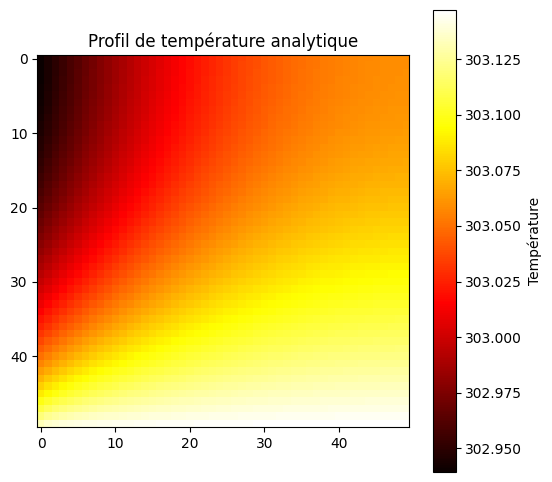

In [ ]:
# Solution analytique
n_solutions = 100
liste_solutions = find_first_n_solutions(Lx, h, k, n_solutions)
print(liste_solutions)

T_analytical = generate_analytical_profile(nx, ny, Lx, Ly, T1, Ta, h, k, 90, liste_solutions)

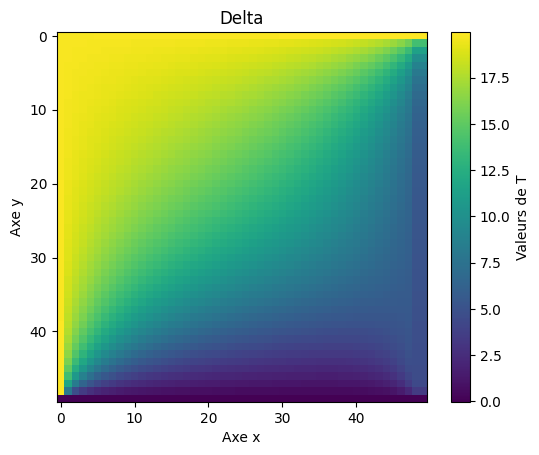

In [ ]:
# Comparison
Delta = T_analytical - T_numerical
# print(T_analytical)
# print(T_numerical)
# print(Delta)
# print(Delta)

plt.imshow(Delta)
plt.colorbar(label='Valeurs de T')
plt.xlabel('Axe x')
plt.ylabel('Axe y')
plt.title('Delta')
plt.show()